In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle

import sys 
sys.path.append('../../')
from model_comparison.utils import *

%matplotlib inline
import matplotlib as mpl
mpl_params = {'legend.fontsize': 15,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

### Analyze single data file 

In [9]:
filename = '201802241353_k1_2.0_th1_25.0_k2_2.0_th2_5.0_k3_1.0_th3_5_N100000M10'

save_figure = True
path_to_save_folder = '../figures/' + filename

time_str = filename[:filename.find('_')]
filename.find('_')
fullname = os.path.join('../data/', filename + '.p')
fullname

'../data/201802241353_k1_2.0_th1_25.0_k2_2.0_th2_5.0_k3_1.0_th3_5_N100000M10.p'

In [10]:
assert os.path.exists(fullname), 'path not found: {}. '.format(fullname)
with open(fullname, 'rb') as handle:
    result_dict = pickle.load(handle)
result_dict.keys()

dict_keys(['priors', 'data', 'model', 'results', 'params'])

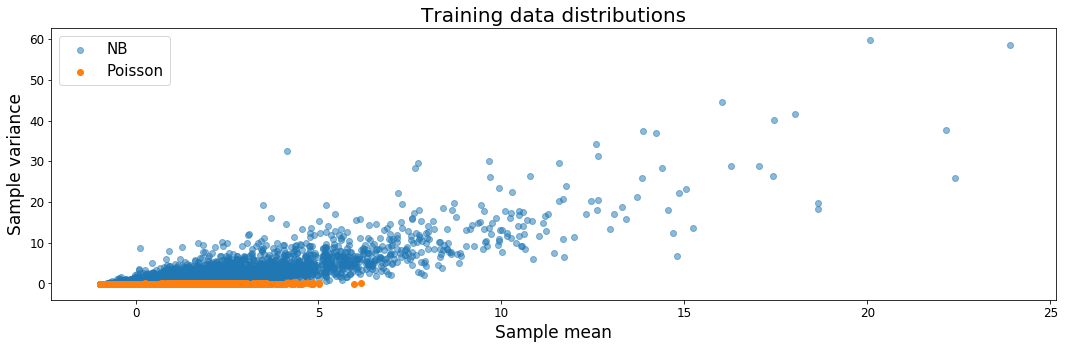

In [11]:
SX = result_dict['data']['SX']
m = result_dict['data']['m']

plt.scatter(SX[np.array(m) == 1, 0], SX[np.array(m)==1, 1], alpha=.5, label='NB')
plt.scatter(SX[np.array(m) == 0, 0], SX[np.array(m)==0, 1], label='Poisson')
plt.legend()
plt.xlabel('Sample mean')
plt.ylabel('Sample variance')
plt.title('Training data distributions');

In [12]:
ppoi_predicted = result_dict['results']['ppoi_predicted']
ppoi_ana = result_dict['results']['ppoi_ana']
print(calculate_mse(ppoi_predicted, ppoi_ana))

0.004979337597639422


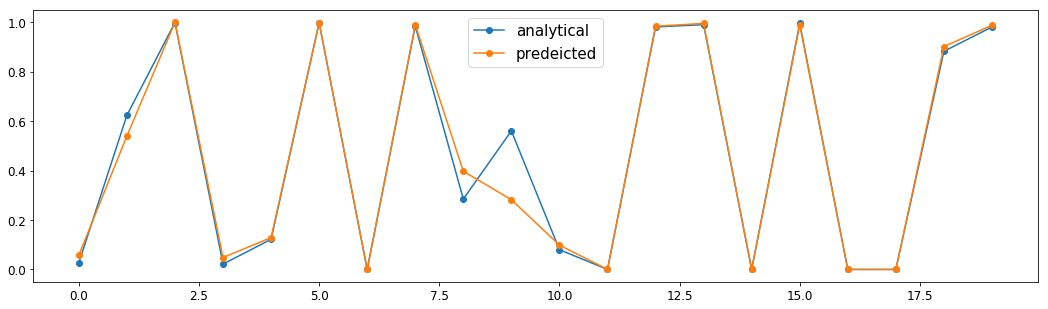

In [13]:
plt.plot(ppoi_ana, 'o-', label='analytical')
plt.plot(ppoi_predicted, '-o', label='predeicted')
plt.legend();

## Analyze set of data files

In [36]:
def get_params(filename): 
    
    params = dict()

    for p in ['k1', 'k2', 'k3', 'th1', 'th2', 'th3']: 

        i = filename.find(p + '_') + len(p) + 1
        j = filename[i:].find('_') + i
        params[p] = float(filename[i:j])

    return params

def get_dict(filename):
    fullname = os.path.join('../data/', filename)
    with open(fullname, 'rb') as handle:
        result_dict = pickle.load(handle)
    
    return result_dict

In [37]:
file_selecter = 'M10.p'

filelist = [f for f in os.listdir('../data/') if file_selecter in f]

p_prior_scales = []
mses = []
p_priors = []
mms_p = []
mvs_p = []
mms_nb = []
mvs_nb = []

for filename in filelist: 
    
    params = get_params(filename)
    result_dict = get_dict(filename)
    
    ppoi_predicted = result_dict['results']['ppoi_predicted']
    ppoi_ana = result_dict['results']['ppoi_ana']
    mses.append(calculate_mse(ppoi_predicted, ppoi_ana))
    p_prior_scales.append(params['th3'])
    p_priors.append(result_dict['priors']['prior_theta'])
    
    poi_mask = np.array(result_dict['data']['m']) == 0
    
    mms_p.append(result_dict['data']['SX'][poi_mask, 0].mean())
    mvs_p.append(result_dict['data']['SX'][poi_mask, 1].mean())
    mms_nb.append(result_dict['data']['SX'][np.logical_not(poi_mask), 0].mean())
    mvs_nb.append(result_dict['data']['SX'][np.logical_not(poi_mask), 1].mean())
    

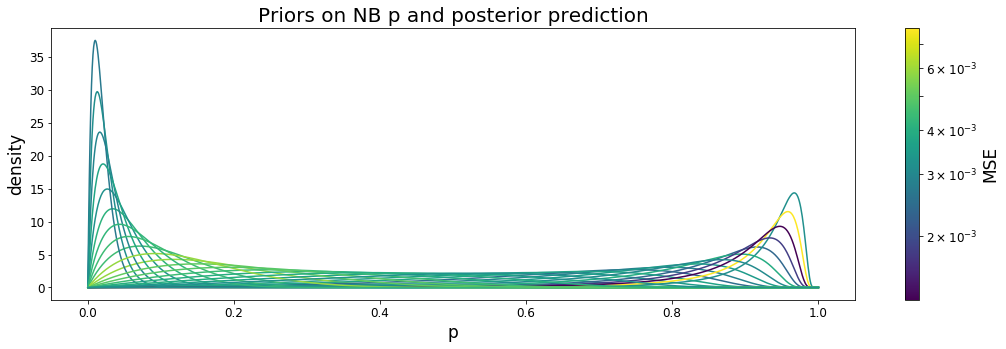

In [38]:
cmap = mpl.colors.LogNorm(vmin=np.min(mses), vmax=np.max(mses))
scalarMap = mpl.cm.ScalarMappable(norm=cmap, cmap='viridis')
scalarMap.set_array([])

values = np.linspace(1e-8, 1-1e-8, 1000)
for prior_theta, mse in zip(p_priors, mses): 
    
    def prior_p(p): return np.power(1-p, -2) * prior_theta.pdf(p / (1 - p))

    plt.plot(values, prior_p(values), color=scalarMap.to_rgba(mse))
plt.colorbar(scalarMap, label='MSE')
plt.title('Priors on NB p and posterior prediction')
plt.xlabel('p')
plt.ylabel('density');